Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded image: a10_aug_0.png
Image shape: (1, 512, 512, 3) | Mask shape: (1, 512, 512, 1)
Saved comparison for epoch 10
Saved comparison for epoch 20
Saved comparison for epoch 30
Saved comparison for epoch 40
Saved comparison for epoch 50
Saved comparison for epoch 60
Saved comparison for epoch 70
Saved comparison for epoch 80
Saved comparison for epoch 90
Saved comparison for epoch 100
Saved comparison for epoch 110
Saved comparison for epoch 120
Saved comparison for epoch 130
Saved comparison for epoch 140
Saved comparison for epoch 150
Saved comparison for epoch 160
Saved comparison for epoch 170
Saved comparison for epoch 180
Saved comparison for epoch 190
Saved comparison for epoch 200
Saved comparison for epoch 210
Saved comparison for epoch 220
Saved comparison for epoch 230
Saved comparison for epoch 240
Saved comparison for epoch 250
Saved comparison

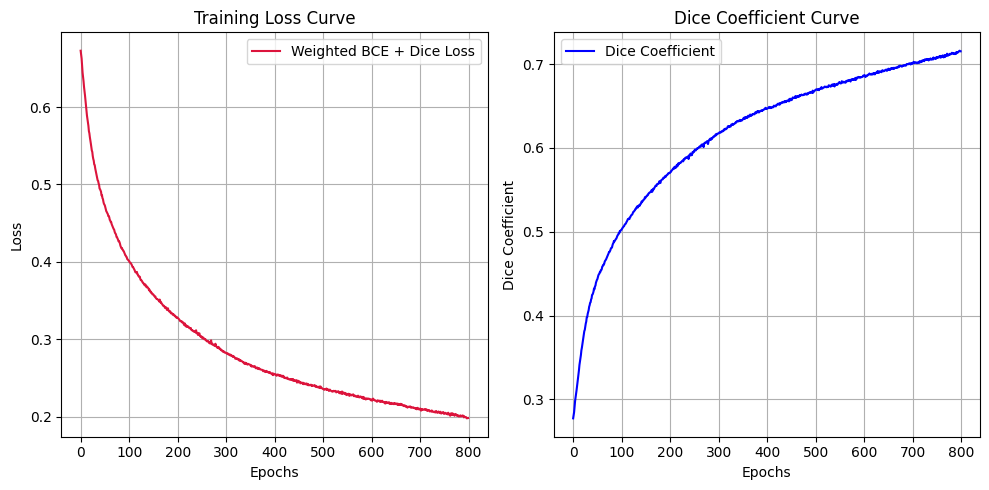

All results (images + loss curves) saved in: /content/drive/MyDrive/Hela_cells_dataset/single_image_results_512_matplot


In [2]:
# ============================================================
# CNNT + Convolutional-Transformer Decoder (Single Image, 512x512, 800 epochs)
# Saves True vs Predicted Mask every 10 epochs and loss curves
# ============================================================

import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation,
                                     MaxPooling2D, Add, Concatenate, Dropout, DepthwiseConv2D, Layer)
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import numpy as np, os, glob, cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import drive

# ---------------- Mount Drive ----------------
drive.mount('/content/drive')

# ---------------- Dataset paths ----------------
image_dir = "/content/drive/MyDrive/Hela_cells_dataset/images"
mask_dir  = "/content/drive/MyDrive/Hela_cells_dataset/masks"
save_dir  = "/content/drive/MyDrive/Hela_cells_dataset/single_image_results_512_matplot"
os.makedirs(save_dir, exist_ok=True)

# ---------------- Load Single Image (512×512) ----------------
def load_one_pair(image_dir, mask_dir, size=(512,512)):
    files = sorted(glob.glob(os.path.join(image_dir, "*.png")))
    if len(files) == 0:
        raise ValueError("❌ No images found in directory.")
    img_path = files[0]
    mask_path = os.path.join(mask_dir, os.path.basename(img_path))
    x = img_to_array(load_img(img_path, target_size=size)) / 255.
    y = img_to_array(load_img(mask_path, target_size=size, color_mode="grayscale")) / 255.
    y = (y > 0.5).astype(np.float32)
    return np.expand_dims(x, 0), np.expand_dims(y, 0), img_path

# ---------------- Model Layers ----------------
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, affine=False, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon; self.affine = affine
    def build(self, input_shape):
        if self.affine:
            self.gamma = self.add_weight(shape=(input_shape[-1],), initializer="ones", trainable=True)
            self.beta  = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        super().build(input_shape)
    def call(self, x):
        mean, var = tf.nn.moments(x, axes=[1,2], keepdims=True)
        x = (x - mean) / tf.sqrt(var + self.epsilon)
        if self.affine:
            x = x * self.gamma + self.beta
        return x

class MultiHeadConvQKAttention(Layer):
    def __init__(self, heads=4, kernel_size=3, ff_dim=None, **kwargs):
        super().__init__(**kwargs)
        self.heads=heads; self.kernel_size=kernel_size; self.ff_dim=ff_dim
    def build(self, input_shape):
        c = input_shape[-1]
        self.q = Conv2D(c,1,padding="same",use_bias=False)
        self.k = Conv2D(c,1,padding="same",use_bias=False)
        self.v = Conv2D(c,1,padding="same",use_bias=False)
        self.fuse = Conv2D(c,1,padding="same",use_bias=False)
        self.bn, self.act = BatchNormalization(), Activation("relu")
        super().build(input_shape)
    def call(self,x):
        q=self.q(x); k=self.k(x); v=self.v(x)
        bs=tf.shape(x)[0]; H=tf.shape(x)[1]; W=tf.shape(x)[2]; C=tf.shape(x)[3]
        ks=self.kernel_size; ka=ks*ks
        q=tf.reshape(q,[bs,H,W,self.heads,C//self.heads])
        pk=tf.image.extract_patches(k,[1,ks,ks,1],[1,1,1,1],[1,1,1,1],'SAME')
        pv=tf.image.extract_patches(v,[1,ks,ks,1],[1,1,1,1],[1,1,1,1],'SAME')
        pk=tf.reshape(pk,[bs,H,W,ka,self.heads,C//self.heads])
        pv=tf.reshape(pv,[bs,H,W,ka,self.heads,C//self.heads])
        qexp=tf.expand_dims(q,3)
        sim=tf.reduce_sum(qexp*pk,axis=-1)/tf.sqrt(tf.cast(C//self.heads,tf.float32))
        att=tf.nn.softmax(sim,axis=3)[...,None]
        out=tf.reduce_sum(att*pv,axis=3)
        out=tf.reshape(out,[bs,H,W,C])
        out=self.fuse(out); out=self.bn(out); out=self.act(out)
        return out

# ---------------- Encoder/Decoder ----------------
def cnnt_cell(x,heads=4,ff_dim=None,dropout=0.2):
    res=x
    x=InstanceNormalization()(x)
    x=Add()([x,res])
    att=MultiHeadConvQKAttention(heads=heads,ff_dim=ff_dim)(x)
    x=InstanceNormalization()(att)
    ch=x.shape[-1]
    x=Conv2D(ch,3,padding="same",use_bias=False)(x)
    x=Activation('gelu')(x)
    x=Conv2D(ch,3,padding="same",use_bias=False)(x)
    x=Dropout(dropout)(x)
    x=Add()([x,att])
    return x

def down_block(x,cells=2,heads=4,ff_dim=128,dropout=0.2):
    for _ in range(cells): x=cnnt_cell(x,heads,ff_dim,dropout)
    skip=x
    x=MaxPooling2D()(x)
    return x,skip

def build_encoder(img_size=(512,512,3),base_filters=16,depth=3):
    inp=Input(shape=img_size)
    x=Conv2D(base_filters,3,padding="same")(inp)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    skips=[]
    for _ in range(depth):
        x,sk=down_block(x)
        skips.append(sk)
    for _ in range(3):
        x=cnnt_cell(x)
    return inp,x,skips

def boundary_refine(x):
    c=x.shape[-1]
    y=DepthwiseConv2D(3,padding="same",dilation_rate=2)(x)
    y=BatchNormalization()(y)
    y=Activation("relu")(y)
    y=Conv2D(c,1,padding="same")(y)
    y=BatchNormalization()(y)
    out=Add()([x,y]); out=Activation("relu")(out)
    return out

def decoder(bottleneck,skips,num_classes=1):
    x=bottleneck
    for sk in reversed(skips):
        ch=sk.shape[-1]
        x=Conv2DTranspose(ch,2,strides=2,padding="same")(x)
        x=BatchNormalization()(x); x=Activation("relu")(x)
        x=Concatenate()([x,sk])
        x=MultiHeadConvQKAttention(heads=4)(x)
        x=boundary_refine(x)
    x=Conv2D(max(16,int(x.shape[-1])//2),3,padding="same")(x)
    x=BatchNormalization()(x); x=Activation("relu")(x)
    out=Conv2D(num_classes,1,activation="sigmoid")(x)
    return out

# ---------------- Build Model ----------------
inp,bottleneck,skips = build_encoder()
out = decoder(bottleneck,skips)
model = Model(inp,out,name="CNNT_CT_SingleImage_512")

# ---------------- Loss & Metric ----------------
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f=K.flatten(y_true); y_pred_f=K.flatten(y_pred)
    inter=K.sum(y_true_f*y_pred_f)
    return (2.*inter+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)+smooth)

def bce_dice_loss(alpha=0.7):
    def loss(y_true,y_pred):
        bce=tf.keras.losses.binary_crossentropy(y_true,y_pred)
        dice=1-dice_coefficient(y_true,y_pred)
        return alpha*tf.reduce_mean(bce)+(1-alpha)*dice
    return loss

# ---------------- Load Data ----------------
x, y, img_path = load_one_pair(image_dir, mask_dir)
print("Loaded image:", os.path.basename(img_path))
print("Image shape:", x.shape, "| Mask shape:", y.shape)

# ---------------- Compile ----------------
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=bce_dice_loss(),
              metrics=[dice_coefficient])

# ---------------- Train, Save Images & Record Loss ----------------
losses, dice_scores = [], []

for epoch in range(1, 801):
    hist = model.fit(x, y, epochs=1, verbose=0)
    losses.append(hist.history['loss'][0])
    dice_scores.append(hist.history['dice_coefficient'][0])

    if epoch % 10 == 0:
        pred = model.predict(x, verbose=0)
        mask_pred = (pred[0, :, :, 0] > 0.5).astype(np.uint8) * 255
        true_mask = (y[0, :, :, 0] * 255).astype(np.uint8)

        plt.figure(figsize=(12,6))
        plt.subplot(1,2,1); plt.imshow(true_mask, cmap='gray'); plt.title("True Mask"); plt.axis('off')
        plt.subplot(1,2,2); plt.imshow(mask_pred, cmap='gray'); plt.title(f"Predicted Mask (Epoch {epoch})"); plt.axis('off')
        plt.suptitle(f"Epoch {epoch} - True vs Predicted Mask", fontsize=14, fontweight='bold')
        plt.subplots_adjust(wspace=0.3)
        plt.savefig(f"{save_dir}/epoch_{epoch:03d}_comparison.png", bbox_inches='tight')
        plt.close()

        print(f"Saved comparison for epoch {epoch}")

# ---------------- Plot Loss Curves ----------------
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(losses, color='crimson', label='Weighted BCE + Dice Loss')
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.plot(dice_scores, color='blue', label='Dice Coefficient')
plt.xlabel("Epochs"); plt.ylabel("Dice Coefficient")
plt.title("Dice Coefficient Curve")
plt.grid(True); plt.legend()

plt.tight_layout()
plt.savefig(f"{save_dir}/training_loss_curves.png", bbox_inches='tight')
plt.show()

print(f"All results (images + loss curves) saved in: {save_dir}")


Saved Matplotlib figure for epoch 10
Saved Matplotlib figure for epoch 20
Saved Matplotlib figure for epoch 30
Saved Matplotlib figure for epoch 40
Saved Matplotlib figure for epoch 50
Saved Matplotlib figure for epoch 60
Saved Matplotlib figure for epoch 70
Saved Matplotlib figure for epoch 80
Saved Matplotlib figure for epoch 90
Saved Matplotlib figure for epoch 100
Saved Matplotlib figure for epoch 110
Saved Matplotlib figure for epoch 120
Saved Matplotlib figure for epoch 130
Saved Matplotlib figure for epoch 140
Saved Matplotlib figure for epoch 150
Saved Matplotlib figure for epoch 160
Saved Matplotlib figure for epoch 170
Saved Matplotlib figure for epoch 180
Saved Matplotlib figure for epoch 190
Saved Matplotlib figure for epoch 200
Saved Matplotlib figure for epoch 210
Saved Matplotlib figure for epoch 220
Saved Matplotlib figure for epoch 230
Saved Matplotlib figure for epoch 240
Saved Matplotlib figure for epoch 250
Saved Matplotlib figure for epoch 260
Saved Matplotlib figu

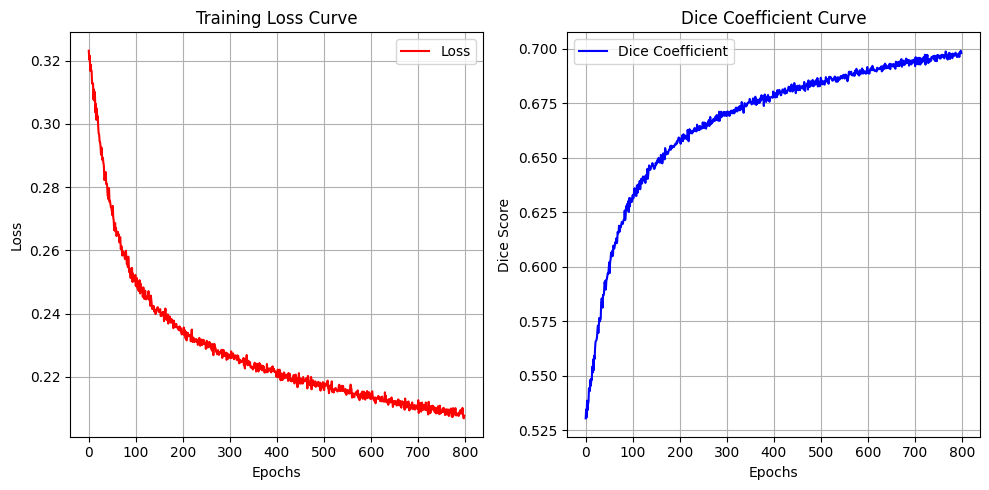

In [20]:
# ---------------- Train & Record Loss Curves ----------------
losses, dice_scores, bce_losses, dice_losses = [], [], [], []

for epoch in range(1, 801):
    # Train for one epoch and get metrics
    hist = model.fit(x, y, epochs=1, verbose=0)
    total_loss = hist.history['loss'][0]
    dice_score = hist.history['dice_coefficient'][0]

    # Approximate BCE and Dice parts separately
    y_pred = model.predict(x, verbose=0)
    bce = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y, y_pred)).numpy()
    dice = 1 - dice_coefficient(tf.convert_to_tensor(y), tf.convert_to_tensor(y_pred)).numpy()

    # Store metrics
    losses.append(total_loss)
    dice_scores.append(dice_score)
    bce_losses.append(bce)
    dice_losses.append(dice)

    # Log progress
    if epoch % 50 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Loss: {total_loss:.4f} | BCE: {bce:.4f} | Dice: {dice:.4f} | DiceCoef: {dice_score:.4f}")

# ---------------- Plot and Save Curves ----------------
plt.figure(figsize=(14,5))

# Weighted BCE + Dice loss
plt.subplot(1,3,1)
plt.plot(losses, color='crimson', label='Weighted BCE + Dice Loss')
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.title("Weighted BCE + Dice Loss")
plt.grid(True); plt.legend()

# BCE loss
plt.subplot(1,3,2)
plt.plot(bce_losses, color='orange', label='BCE Loss')
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.title("Binary Cross-Entropy (BCE) Loss")
plt.grid(True); plt.legend()

# Dice Coefficient (accuracy)
plt.subplot(1,3,3)
plt.plot(dice_scores, color='blue', label='Dice Coefficient')
plt.xlabel("Epochs"); plt.ylabel("Dice Score")
plt.title("Dice Coefficient Curve")
plt.grid(True); plt.legend()

plt.tight_layout()
plt.savefig(f"{save_dir}/training_loss_curves.png", bbox_inches='tight')
plt.show()

print(f" Loss curves saved at: {save_dir}/training_loss_curves.png")


In [8]:
# ============================================================
# Print Model Summary & Parameter Counts (Fixed)
# ============================================================

# Full model summary
full_model.summary()

# Compute trainable and non-trainable parameter counts safely
trainable_params = np.sum([np.prod(v.shape.as_list()) for v in full_model.trainable_weights])
non_trainable_params = np.sum([np.prod(v.shape.as_list()) for v in full_model.non_trainable_weights])
total_params = trainable_params + non_trainable_params

print("\n============================")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")
print("============================")


Model: "CNNT_CT_Segmentation"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_147 (Conv2D) │ (None, 128, 128,  │        448 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_147[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_66       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 128, 128,  │          0 │ activation_66[0]… │
│ (InstanceNormaliza… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_42 (Add)        │ (None, 128, 128,  │          0 │ instance_normali… │
│                     │ 16)               │            │ activation_66[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_conv_qk… │ (None, 128, 128,  │      1,088 │ add_42[0][0]      │
│ (MultiHeadConvQKAt… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 128, 128,  │          0 │ multi_head_conv_… │
│ (InstanceNormaliza… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_152 (Conv2D) │ (None, 128, 128,  │      2,304 │ instance_normali… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_68       │ (None, 128, 128,  │          0 │ conv2d_152[0][0]  │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_153 (Conv2D) │ (None, 128, 128,  │      2,304 │ activation_68[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 128, 128,  │          0 │ conv2d_153[0][0]  │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_43 (Add)        │ (None, 128, 128,  │          0 │ dropout_18[0][0], │
│                     │ 16)               │            │ multi_head_conv_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 128, 128,  │          0 │ add_43[0][0]      │
│ (InstanceNormaliza… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_44 (Add)        │ (None, 128, 128,  │          0 │ instance_normali… │
│                     │ 16)               │            │ add_43[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_conv_qk… │ (None, 128, 128,  │      1,088 │ add_44[0][0]      │
│ (MultiHeadConvQKAt… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 128, 128,  │          0 │ multi_head_conv_

 Total params: 54,337 (212.25 KB)

 Trainable params: 53,633 (209.50 KB)

 Non-trainable params: 704 (2.75 KB)


Total Parameters: 54,337
Trainable Parameters: 53,633
Non-Trainable Parameters: 704


✅ Found 5 valid image–mask pairs (e.g. '1' ↔ '1_mask').
Loaded data: (5, 512, 512, 3) (5, 512, 512, 1)
Fine-tuning CNNT+Transformer on Stress Granule data...
Epoch 5/50 | Loss: 0.4459 | Dice: 0.4652
Epoch 10/50 | Loss: 0.4375 | Dice: 0.4747
Epoch 15/50 | Loss: 0.4242 | Dice: 0.4892
Epoch 20/50 | Loss: 0.4144 | Dice: 0.4996
Epoch 25/50 | Loss: 0.4072 | Dice: 0.5076
Epoch 30/50 | Loss: 0.3958 | Dice: 0.5185
Epoch 35/50 | Loss: 0.3918 | Dice: 0.5233
Epoch 40/50 | Loss: 0.3858 | Dice: 0.5290
Epoch 45/50 | Loss: 0.3779 | Dice: 0.5375
Epoch 50/50 | Loss: 0.3719 | Dice: 0.5439


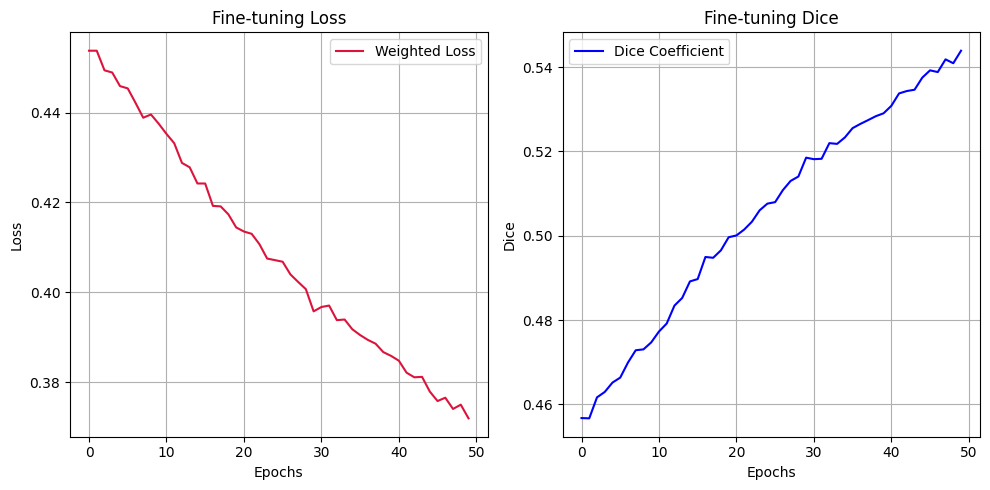

Predicting refined masks...


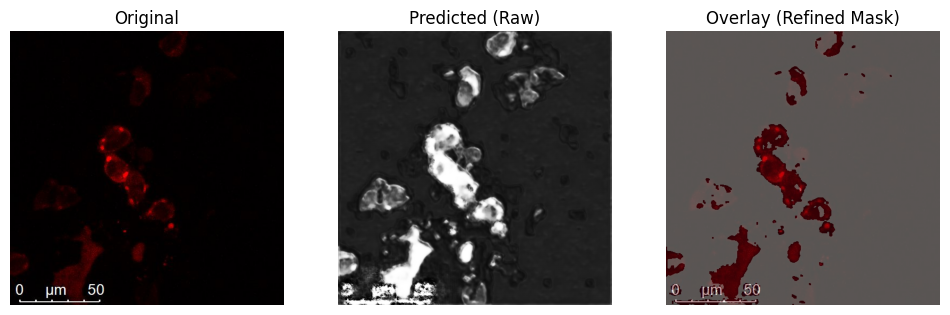

Saved: /content/drive/MyDrive/Masked and unmasked imagess/fine_tuned_results/mask_refined_1.png


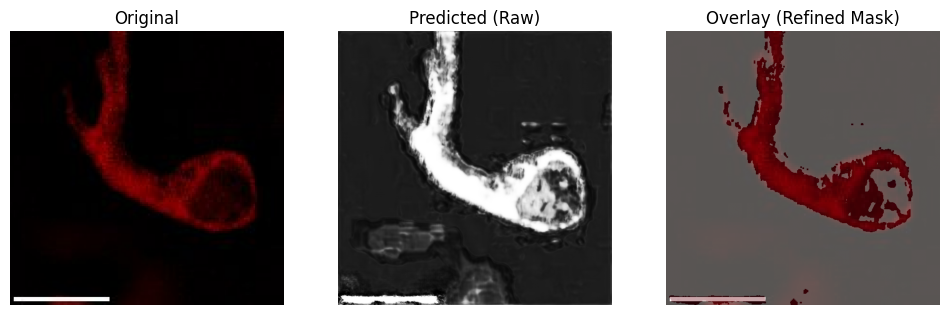

Saved: /content/drive/MyDrive/Masked and unmasked imagess/fine_tuned_results/mask_refined_2.png


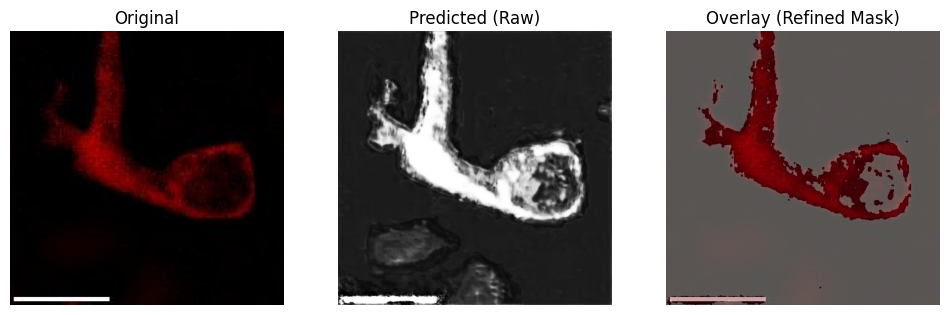

Saved: /content/drive/MyDrive/Masked and unmasked imagess/fine_tuned_results/mask_refined_3.png
Saved: /content/drive/MyDrive/Masked and unmasked imagess/fine_tuned_results/mask_refined_4.png
Saved: /content/drive/MyDrive/Masked and unmasked imagess/fine_tuned_results/mask_refined_9.png
All fine-tuned results saved in: /content/drive/MyDrive/Masked and unmasked imagess/fine_tuned_results


In [15]:
# ============================================================
# Fine-tune Existing CNNT + Transformer on Stress Granules (5 imgs)
# ============================================================

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np, os, glob, cv2

# ---- Paths ----
image_dir = "/content/drive/MyDrive/Masked and unmasked imagess/images"
mask_dir  = "/content/drive/MyDrive/Masked and unmasked imagess/Masked Images"
save_dir  = "/content/drive/MyDrive/Masked and unmasked imagess/fine_tuned_results"
os.makedirs(save_dir, exist_ok=True)

# ---- Loader that matches 1.jpg ↔ 1_mask.png ----
def load_pairs(image_dir, mask_dir, size=(512,512)):
    imgs, masks, names = [], [], []
    image_exts = ("*.jpg","*.jpeg","*.png","*.tif","*.tiff")
    mask_exts  = ("*.png","*.jpg","*.jpeg","*.tif","*.tiff")

    image_files, mask_files = [], []
    for e in image_exts: image_files += glob.glob(os.path.join(image_dir, e))
    for e in mask_exts:  mask_files  += glob.glob(os.path.join(mask_dir, e))
    image_files, mask_files = sorted(image_files), sorted(mask_files)

    for img_path in image_files:
        img_base = os.path.splitext(os.path.basename(img_path))[0].lower()
        match = None
        for mask_path in mask_files:
            mask_base = os.path.splitext(os.path.basename(mask_path))[0].lower()
            if img_base in mask_base: match = mask_path; break
        if not match: continue
        im = img_to_array(load_img(img_path, target_size=size)) / 255.0
        ma = img_to_array(load_img(match, target_size=size, color_mode="grayscale")) / 255.0
        ma = (ma > 0.5).astype(np.float32)
        imgs.append(im); masks.append(ma); names.append(os.path.basename(img_path))
    print(f"✅ Found {len(imgs)} valid image–mask pairs (e.g. '1' ↔ '1_mask').")
    return np.array(imgs, np.float32), np.array(masks, np.float32), names

# ---- Load 5 stress granule pairs ----
x_stress, y_stress, file_names = load_pairs(image_dir, mask_dir)
print("Loaded data:", x_stress.shape, y_stress.shape)

# ---- Fine-tune current model (in-memory) ----
print("Fine-tuning CNNT+Transformer on Stress Granule data...")

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=bce_dice_loss(),
    metrics=[dice_coefficient]
)

epochs = 50
losses, dice_scores = [], []

for epoch in range(1, epochs+1):
    hist = model.fit(x_stress, y_stress, epochs=1, batch_size=1, verbose=0)
    losses.append(hist.history['loss'][0])
    dice_scores.append(hist.history['dice_coefficient'][0])
    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{epochs} | Loss: {losses[-1]:.4f} | Dice: {dice_scores[-1]:.4f}")

# ---- Plot loss + dice curves ----
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(losses, label='Weighted Loss', color='crimson')
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.title("Fine-tuning Loss"); plt.grid(True); plt.legend()
plt.subplot(1,2,2)
plt.plot(dice_scores, label='Dice Coefficient', color='blue')
plt.xlabel("Epochs"); plt.ylabel("Dice"); plt.title("Fine-tuning Dice"); plt.grid(True); plt.legend()
plt.tight_layout()
plt.savefig(f"{save_dir}/fine_tune_curves.png", bbox_inches='tight')
plt.show()

# ---- Predict and save refined masks ----
print("Predicting refined masks...")
for idx, img in enumerate(x_stress):
    pred = model.predict(np.expand_dims(img, 0), verbose=0)[0, :, :, 0]
    pred_bin = (pred > 0.5).astype(np.uint8) * 255
    pred_bin = cv2.morphologyEx(pred_bin, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    base = file_names[idx]
    out_path = os.path.join(save_dir, f"mask_refined_{os.path.splitext(base)[0]}.png")
    cv2.imwrite(out_path, pred_bin)

    if idx < 3:
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(pred, cmap="gray"); plt.title("Predicted (Raw)"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(img); plt.imshow(pred_bin, cmap="Reds", alpha=0.35)
        plt.title("Overlay (Refined Mask)"); plt.axis("off")
        plt.show()

    print(f"Saved: {out_path}")

print(f"All fine-tuned results saved in: {save_dir}")


In [16]:
# ============================================================
# Quick Fine-tuning Visualization (Matplotlib saves every 5 epochs)
# ============================================================

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np, os, glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ---- Paths ----
image_dir = "/content/drive/MyDrive/Masked and unmasked imagess/images"
mask_dir  = "/content/drive/MyDrive/Masked and unmasked imagess/Masked Images"
save_dir  = "/content/drive/MyDrive/Masked and unmasked imagess/epoch_progress"
os.makedirs(save_dir, exist_ok=True)

# ---- Load the 5 image-mask pairs ----
def load_pairs(image_dir, mask_dir, size=(512,512)):
    imgs, masks = [], []
    for img_path in sorted(glob.glob(os.path.join(image_dir,"*.jpg"))):
        base = os.path.splitext(os.path.basename(img_path))[0]
        mask_path = os.path.join(mask_dir, f"{base}_mask.png")
        if not os.path.exists(mask_path): continue
        im = img_to_array(load_img(img_path, target_size=size)) / 255.0
        ma = img_to_array(load_img(mask_path, target_size=size, color_mode="grayscale")) / 255.0
        ma = (ma > 0.5).astype(np.float32)
        imgs.append(im); masks.append(ma)
    return np.array(imgs,np.float32), np.array(masks,np.float32)

x_stress, y_stress = load_pairs(image_dir, mask_dir)
print("Loaded:", x_stress.shape, y_stress.shape)

# ---- Compile your existing model ----
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=bce_dice_loss(),
    metrics=[dice_coefficient]
)

# ---- Train for 100 epochs and save Matplotlib figures ----
epochs = 100
for epoch in range(1, epochs+1):
    model.fit(x_stress, y_stress, epochs=1, batch_size=1, verbose=0)

    if epoch % 5 == 0:
        pred = model.predict(x_stress, verbose=0)
        y_true = (y_stress[0,:,:,0]*255).astype(np.uint8)
        y_pred = (pred[0,:,:,0]>0.5).astype(np.uint8)*255

        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(y_true, cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(y_pred, cmap='gray')
        plt.title(f"Predicted Mask (Epoch {epoch})")
        plt.axis('off')

        plt.suptitle(f"Epoch {epoch} — True vs Predicted", fontsize=14, fontweight='bold')
        plt.subplots_adjust(wspace=0.3, top=0.88)
        plt.savefig(f"{save_dir}/epoch_{epoch:03d}_comparison.png", bbox_inches='tight')
        plt.close()

        print(f"Saved Matplotlib figure for epoch {epoch}")

print(f"All results saved in: {save_dir}")


Loaded: (5, 512, 512, 3) (5, 512, 512, 1)
Saved Matplotlib figure for epoch 5
Saved Matplotlib figure for epoch 10
Saved Matplotlib figure for epoch 15
Saved Matplotlib figure for epoch 20
Saved Matplotlib figure for epoch 25
Saved Matplotlib figure for epoch 30
Saved Matplotlib figure for epoch 35
Saved Matplotlib figure for epoch 40
Saved Matplotlib figure for epoch 45
Saved Matplotlib figure for epoch 50
Saved Matplotlib figure for epoch 55
Saved Matplotlib figure for epoch 60
Saved Matplotlib figure for epoch 65
Saved Matplotlib figure for epoch 70
Saved Matplotlib figure for epoch 75
Saved Matplotlib figure for epoch 80
Saved Matplotlib figure for epoch 85
Saved Matplotlib figure for epoch 90
Saved Matplotlib figure for epoch 95
Saved Matplotlib figure for epoch 100
All results saved in: /content/drive/MyDrive/Masked and unmasked imagess/epoch_progress


In [13]:
import glob, os

image_dir = "/content/drive/MyDrive/Masked and unmasked imagess/images"
mask_dir  = "/content/drive/MyDrive/Masked and unmasked imagess/Masked Images"

print("Images:")
for f in sorted(glob.glob(os.path.join(image_dir, "*"))):
    print("  ", os.path.basename(f))

print("\nMasks:")
for f in sorted(glob.glob(os.path.join(mask_dir, "*"))):
    print("  ", os.path.basename(f))


Images:
   1.jpg
   2.jpg
   3.jpg
   4.jpg
   9.jpg

Masks:
   1_mask.png
   2_mask.png
   3_mask.png
   4_mask.png
   9_mask.png


In [19]:
# ============================================================
# Save Grayscale Predicted Masks for All Stress Granule Images
# ============================================================

import os, glob, numpy as np, cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ---- Paths ----
image_dir = "/content/drive/MyDrive/Masked and unmasked imagess/images"
save_dir  = "/content/drive/MyDrive/Masked and unmasked imagess/greyscale_predictions"
os.makedirs(save_dir, exist_ok=True)

# ---- Collect all images ----
image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")) +
                     glob.glob(os.path.join(image_dir, "*.jpeg")) +
                     glob.glob(os.path.join(image_dir, "*.png")))

print(f"Found {len(image_paths)} images for prediction.")

# ---- Predict and save ----
for idx, img_path in enumerate(image_paths):
    # Load and preprocess
    img = img_to_array(load_img(img_path, target_size=(512,512))) / 255.0
    pred = model.predict(np.expand_dims(img, 0), verbose=0)[0, :, :, 0]

    # Normalize prediction (0–255 grayscale)
    pred_norm = (pred - np.min(pred)) / (np.max(pred) + 1e-8)
    pred_gray = (pred_norm * 255).astype(np.uint8)

    # Save predicted grayscale mask
    base = os.path.basename(img_path)
    name = os.path.splitext(base)[0]
    out_path = os.path.join(save_dir, f"{name}_predicted_gray.png")
    cv2.imwrite(out_path, pred_gray)

    print(f"Saved: {out_path}")

print(f"All grayscale predictions saved in: {save_dir}")


Found 5 images for prediction.
Saved: /content/drive/MyDrive/Masked and unmasked imagess/greyscale_predictions/1_predicted_gray.png
Saved: /content/drive/MyDrive/Masked and unmasked imagess/greyscale_predictions/2_predicted_gray.png
Saved: /content/drive/MyDrive/Masked and unmasked imagess/greyscale_predictions/3_predicted_gray.png
Saved: /content/drive/MyDrive/Masked and unmasked imagess/greyscale_predictions/4_predicted_gray.png
Saved: /content/drive/MyDrive/Masked and unmasked imagess/greyscale_predictions/9_predicted_gray.png
✅ All grayscale predictions saved in: /content/drive/MyDrive/Masked and unmasked imagess/greyscale_predictions
